# 🧪 PyTorch Lab 3: MLP 


## 0) Setup


In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
print('PyTorch version:', torch.__version__)

PyTorch version: 2.8.0+cpu


## 1) Data: load Fashion-MNIST
**Exercise 1.1** — Load the training and test sets with `ToTensor()` transforms. Keep the default split.

Hints:
- Use `datasets.FashionMNIST` with `train=True/False`.
- Use a local folder like `data/` for `root`.
- Set `download=True` on first run.

In [2]:
# TODO: Exercise 1.1 — create `training_data` and `test_data`
training_data = datasets.FashionMNIST(
    root="data", train=True, download=True, transform=ToTensor()
)
test_data = datasets.FashionMNIST(
    root="data", train=False, download=True, transform=ToTensor()
)

training_data, validation_data = train_test_split(training_data, test_size=0.2)

len(training_data), len(validation_data),len(test_data)

(48000, 12000, 10000)

**Exercise 1.2** — Visualize one sample image to verify shapes and ranges.

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

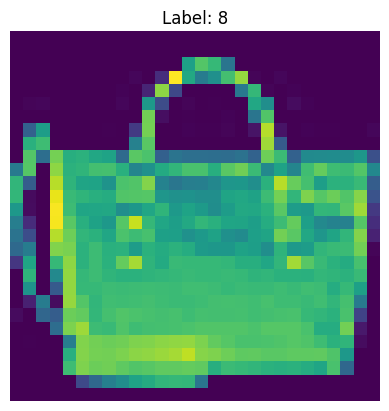

In [3]:
# TODO: Exercise 1.2 — visualize a sample
x0, y0 = training_data[1]
plt.imshow(x0[0].numpy())
plt.title(f"Label: {y0}")
plt.axis('off')

## 2) Dataloaders
**Exercise 2.1** — Create dataloaders for train and test with `batch_size=64`.


In [4]:
# TODO: Exercise 2.1 — make DataLoaders
batch_size = 64
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(validation_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size)


# Peek at a single batch
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


## 3) Device
**Exercise 3.1** — Pick `cuda` if available, else `cpu`.

In [5]:
# TODO: Exercise 3.1 — choose device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


## 4) Model: a tiny autoencoder
We’ll encode 28×28 images → 2D latent, then decode back to 28×28.

**Exercise 4.1** — Implement the following architecture:
- Encoder: Linear(784→256) → Tanh → Linear(256→10)

Return the output reshaped to the original image shape.


In [6]:
# TODO: Exercise 4.1 — implement the autoencoder
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.first = nn.Linear(28*28, 1000)
        self.activation = nn.Tanh()
        self.second = nn.Linear(1000, 10)
    def forward(self, x):
        initial_shape = x.shape
        x = self.flatten(x)
        x = self.activation(self.first(x))
        x = self.second(x)
        return x

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (first): Linear(in_features=784, out_features=1000, bias=True)
  (activation): Tanh()
  (second): Linear(in_features=1000, out_features=10, bias=True)
)


## 5) Loss and Optimizer
**Exercise 5.1** — Use MSE loss to measure reconstruction error. Choose Adam with learning rate 1e-3.


In [7]:
# TODO: Exercise 5.1 — define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

## 6) Training & Evaluation loops
**Exercise 6.1** — Implement a standard training loop.

**Exercise 6.2** — Implement a simple test loop computing loss and accuracy.


In [8]:
# TODO: Exercise 6.1 — training loop (with accuracy)
def train(dataloader_val, dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)

        # Forward
        y_pred = model(X)
        loss = loss_fn(y_pred, y)

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Batch accuracy (argmax for multi-class)
        with torch.no_grad():
            preds = y_pred.argmax(dim=1)
            acc = (preds == y).float().mean().item()

        if batch % 100 == 0:
            loss_item = loss.item()
            current = batch * len(X)
            print(f"loss: {loss_item:>7f} | acc: {acc*100:5.2f}%  [{current:>5d}/{size:>5d}]")
    
    size = len(dataloader_val.dataset)
    num_batches = len(dataloader_val)
    model.eval()
    test_loss = 0.0
    correct = 0

    with torch.no_grad():
        for X, y in dataloader_val:
            X = X.to(device)
            y = y.to(device)

            pred = model(X)
            test_loss += loss_fn(pred, y).item()

            preds = pred.argmax(dim=1)
            correct += (preds == y).type(torch.float).sum().item()

    test_loss /= num_batches
    accuracy = correct / size

    print(f"Val Avg loss: {test_loss:>8f} | val accuracy: {accuracy*100:5.2f}%")

# TODO: Exercise 6.2 — test loop (with accuracy)
def test( dataloader, model, loss_fn):
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0.0
    correct = 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)

            pred = model(X)
            test_loss += loss_fn(pred, y).item()

            preds = pred.argmax(dim=1)
            correct += (preds == y).type(torch.float).sum().item()

    test_loss /= num_batches
    accuracy = correct / size
    print(f"Test Avg loss: {test_loss:>8f} | Test accuracy: {accuracy*100:5.2f}%")


**Exercise 6.3** — Train for a few epochs (e.g., 5) and observe the printed losses.

In [9]:
# TODO: Exercise 6.3 — run training
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(val_dataloader, train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.314828 | acc: 10.94%  [    0/48000]
loss: 0.603730 | acc: 79.69%  [ 6400/48000]
loss: 0.433276 | acc: 84.38%  [12800/48000]
loss: 0.782726 | acc: 75.00%  [19200/48000]
loss: 0.413096 | acc: 85.94%  [25600/48000]
loss: 0.389725 | acc: 85.94%  [32000/48000]
loss: 0.396604 | acc: 85.94%  [38400/48000]
loss: 0.329464 | acc: 90.62%  [44800/48000]
Val Avg loss: 0.449716 | val accuracy: 83.72%
Test Avg loss: 0.473813 | Test accuracy: 82.68%
Epoch 2
-------------------------------
loss: 0.667045 | acc: 79.69%  [    0/48000]
loss: 0.498178 | acc: 78.12%  [ 6400/48000]
loss: 0.467854 | acc: 90.62%  [12800/48000]
loss: 0.396225 | acc: 81.25%  [19200/48000]
loss: 0.374385 | acc: 81.25%  [25600/48000]
loss: 0.510481 | acc: 76.56%  [32000/48000]
loss: 0.299202 | acc: 89.06%  [38400/48000]
loss: 0.397375 | acc: 89.06%  [44800/48000]
Val Avg loss: 0.393799 | val accuracy: 85.93%
Test Avg loss: 0.411958 | Test accuracy: 85.47%
Epoch 3
--------------------